In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

train_path = "C:/Users/samal/Downloads/project_brain/Training"
test_path = "C:/Users/samal/Downloads/project_brain/Testing"

In [9]:
class_names = os.listdir(train_path)
print("Class Names:", class_names)

for class_name in class_names:
    class_path = os.path.join(train_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"{class_name}: {num_images} images")

Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [16]:
def balance_classes(train_path, target_samples=820):
    classes = os.listdir(train_path)
    for class_name in classes:
        class_dir = os.path.join(train_path, class_name)
        images = os.listdir(class_dir)
        if len(images) < target_samples and class_name == 'no_tumor':
            images_to_add = resample(images, replace=True, n_samples=target_samples - len(images))
            for img in images_to_add:
                src = os.path.join(class_dir, img)
                dst = os.path.join(class_dir, f"dup_{img}")
                os.copyfile(src, dst)

balance_classes(train_path)

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("Class indices:", train_generator.class_indices)

Found 5712 images belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [18]:
class_counts = [826, 822, 395, 827]  # Original counts
total = sum(class_counts)
class_weights = {i: total/(len(class_counts)*count) for i, count in enumerate(class_counts)}


In [ ]:
# Model Architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [21]:
model.compile(optimizer=Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:


# Train with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    class_weight=class_weights
)

c:\Users\samal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\samal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.5286 - loss: 1.0970 - val_accuracy: 0.7857 - val_loss: 0.6462
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.7807 - loss: 0.5307 - val_accuracy: 0.8101 - val_loss: 0.5077
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8265 - loss: 0.4180 - val_accuracy: 0.7033 - val_loss: 0.8124
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8522 - loss: 0.3654 - val_accuracy: 0.8207 - val_loss: 0.4427
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8702 - loss: 0.3279 - val_accuracy: 0.8482 - val_loss: 0.3680
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8836 - loss: 0.2756 - val_accuracy: 0.8703 - val_loss: 0.3461
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8969 - loss: 0.2552 - val_accuracy: 0.8726 - val_loss: 0.3193
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9088 - loss: 0.2314 - val_accu

In [22]:


# 1. Get true labels and predictions
test_steps = len(test_generator)
Y_true = test_generator.classes
Y_pred = model.predict(test_generator, steps=test_steps).argmax(axis=1)

# 2. Classification Report
print("Classification Report:\n", classification_report(Y_true, Y_pred, 
      target_names=test_generator.class_indices.keys()))

c:\Users\samal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.22      0.89      0.36       306
     notumor       0.43      0.10      0.16       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.24      1311
   macro avg       0.16      0.25      0.13      1311
weighted avg       0.18      0.24      0.13      1311



c:\Users\samal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

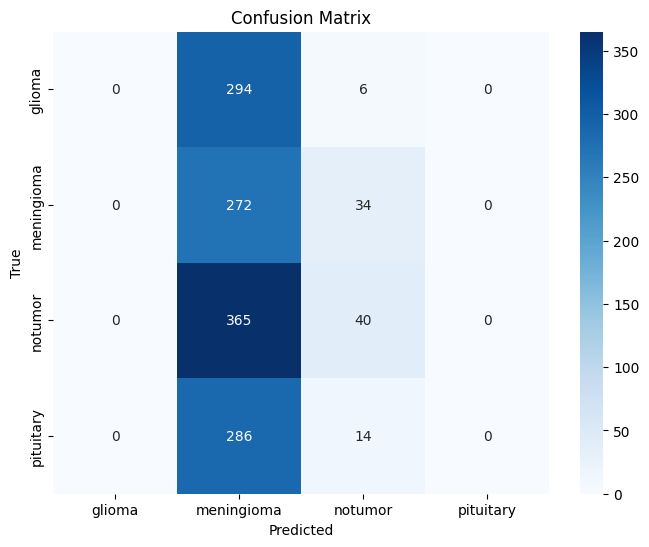

In [24]:
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save("brain_tumor_resnet.h5") 